In [1]:
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gymnasium as gym
import copy
import os
import cv2

## 1. Deep - Q Networks
### a) Develop a small code snippet to load the corresponding Gym environment(s) and print out the respective state and action space. Develop a random agent to understand the reward function of the environment. Record your observations.

In [2]:
env = gym.make("MountainCar-v0")
print("THE MOUNTAIN CAR ENVIRONMENT")

print("State Space:", env.observation_space)
print("Action Space:", env.action_space)
print("\n")

total_reward = 0
num_episodes = 5 

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    episode_reward = 0
    n_steps = 0
    print(f"Initial State = {state}")
    
    while not done:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        n_steps += 1
        done = terminated or truncated
        
    total_reward += episode_reward
    print(f"Done={done}, Last state={next_state}, Last step Reward={reward}")
    print(f"Episode {episode + 1}: Total Reward = {episode_reward}: Total steps = {n_steps}\n")

# Calculate the average reward
average_reward = total_reward / num_episodes
print("Average Reward:", average_reward)
print("So, each episode terminated after 200 steps and each step yielded -1 as reward ")

THE MOUNTAIN CAR ENVIRONMENT
State Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Space: Discrete(3)


Initial State = [-0.5304621  0.       ]
Done=True, Last state=[-0.6413771  -0.00689995], Last step Reward=-1.0
Episode 1: Total Reward = -200.0: Total steps = 200

Initial State = [-0.4696158  0.       ]
Done=True, Last state=[-0.6364174  -0.00934613], Last step Reward=-1.0
Episode 2: Total Reward = -200.0: Total steps = 200

Initial State = [-0.467154  0.      ]
Done=True, Last state=[-0.58924735  0.00472507], Last step Reward=-1.0
Episode 3: Total Reward = -200.0: Total steps = 200

Initial State = [-0.4948633  0.       ]
Done=True, Last state=[-0.41606262  0.0015902 ], Last step Reward=-1.0
Episode 4: Total Reward = -200.0: Total steps = 200

Initial State = [-0.41016945  0.        ]
Done=True, Last state=[-0.5370714   0.02777228], Last step Reward=-1.0
Episode 5: Total Reward = -200.0: Total steps = 200

Average Reward: -200.0
So, each episode terminated after 200 st

### Observations(Mountain-Car)
- The position of the car is assigned a uniform random value in [-0.6 , -0.4]. The starting velocity of the car is always assigned to 0.
- The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of -1 for each timestep.

The observation is a ndarray with shape (2,)

| Observation |  Min   |  Max |
|:--------:|:--------:|:--------:|
|  position of the car along x-axis  |-1.2 | 0.6 |
| velocity of the car | -0.07 | 0.07 |


In [3]:
# pip install gymnasium[atari,accept-rom-license]==0.28.0

In [4]:
env = gym.make("ALE/Pong-v5")
print("THE PONG ENVIRONMENT ")

print("State Space:", env.observation_space)
print("Action Space:", env.action_space)
print("\n")

total_reward = 0
num_episodes = 5 

for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    n_steps = 0
    
    while not done:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        n_steps += 1
        done = terminated or truncated
        
    total_reward += episode_reward
    print(f"Done={done}, Last state shape={np.array(next_state).shape}, Last step Reward={reward}")
    print(f"Episode {episode + 1}: Total Reward = {episode_reward}: Total steps = {n_steps}\n")

# Calculate the average reward
average_reward = total_reward / num_episodes
print("Average Reward:", average_reward)

THE PONG ENVIRONMENT 
State Space: Box(0, 255, (210, 160, 3), uint8)
Action Space: Discrete(6)


Done=True, Last state shape=(210, 160, 3), Last step Reward=-1.0
Episode 1: Total Reward = -20.0: Total steps = 872

Done=True, Last state shape=(210, 160, 3), Last step Reward=-1.0
Episode 2: Total Reward = -21.0: Total steps = 824

Done=True, Last state shape=(210, 160, 3), Last step Reward=-1.0
Episode 3: Total Reward = -20.0: Total steps = 902

Done=True, Last state shape=(210, 160, 3), Last step Reward=-1.0
Episode 4: Total Reward = -21.0: Total steps = 839

Done=True, Last state shape=(210, 160, 3), Last step Reward=-1.0
Episode 5: Total Reward = -21.0: Total steps = 940

Average Reward: -20.6


### Obseravations(Pong)
- There are 6 different actions
- The first player or team to score 21 points wins the game and the game terminates
- You get score points for getting the ball to pass the opponent’s paddle. You lose points if the ball passes your paddle

## DQN algorithm(pseudo code)
1. Initialise replay memory capacity
2. Initialise the action value network with random weights
3. Copy the above network and call it target action value network
4. For episodes 1 to M do
    - Initialise the start state s1
    - for steps t = 1 to T do
        - Select an action via epsilon-greedy policy(exploaration-exploitation)
        - Exectute selected action
        - Observe reward and next state
        - Store experience  $(s_t, a_t, r_t, s_{t+1})$ in D
        - Sample random minibatch (size B) of transitions from D
        - Preprocess STATES from batch if needed(ping-pong)
        - Pass batch of preprocessed STATES ($s_t$)'s to action value network Q
        - Calculate loss b/w output Q-values i.e $Q(s_t, a_t)$ from Q and target Q-values i.e. $r_t + max_{a'} Q'(s_{t+1}, a')$ via Q'
            - Requires a pass to the target network Q' for the next state i.e. ($s_{t+1}$)
        - Gradient descwent updates weights in the action value network to minimise loss
            - Every C steps set Q' = Q

## 1 b) Implement the DQN algorithm to solve the tasks envisioned by the two environments

In [75]:
class DQNetwork(nn.Module):
    def __init__(self, input_size, fc1_size, fc2_size, n_actions, lr):
        super(DQNetwork, self).__init__()
        self.input_size = input_size
        self.fc1_size = fc1_size
        self.fc2_size = fc2_size
        self.lr = lr
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_size, self.fc1_size)
        self.fc2 = nn.Linear(self.fc1_size, self.fc2_size)
        self.fc3 = nn.Linear(self.fc2_size, self.n_actions)
        self.loss = nn.MSELoss()
        self.optimiser = optim.Adam(self.parameters(), lr = lr)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        if self.device.type == 'cuda':
            print("GPU is used")
        else:
            print("CPU is used")
        
        self.to(self.device)
        
    def forward(self, state):
        unactivated_x1 = self.fc1(state)
        activated_x1 = F.relu(unactivated_x1)
        unactivated_x2 = self.fc2(activated_x1)
        activated_x2 = F.relu(unactivated_x2)
        actions = self.fc3(activated_x2)   # WE want the final output to be unactivated because we want RAW VALUES
        
        return actions
    
    
    
class DQN_convnet(nn.Module):
    def __init__(self, lr, n_actions, input_size):
        super(DQN_convnet, self).__init__()
        
        self.target_input_size = (3, 80, 64)
        self.c1 = nn.Conv2d(input_size[0], 32, 8, stride=4)
        self.c2 = nn.Conv2d(32, 64, 4, stride=2)
        self.c3 = nn.Conv2d(64, 64, 3, stride=1) 

        fc_input_size = self.get_conv_output_dims((3, 80, 64))

        self.fc1 = nn.Linear(fc_input_size, 512)
        self.fc2 = nn.Linear(512, n_actions)

        self.optimiser = optim.RMSprop(self.parameters(), lr=lr)

        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        if self.device.type == 'cuda':
            print("GPU is used")
        else:
            print("CPU is used")
            
        self.to(self.device)

        
    def get_conv_output_dims(self, input_size):
        
        state = T.zeros(1, *self.target_input_size)
        dims = self.c1(state)
        dims = self.c2(dims)
        dims = self.c3(dims)
        
        return int(np.prod(dims.size()))

    
    def forward(self, state):
        
        state = state.permute(0, 3, 1, 2)     #[1, 3, 210, 160]
        
        c1 = F.relu(self.c1(state))
        c2 = F.relu(self.c2(c1))
        c3 = F.relu(self.c3(c2))
        
        conv_state = c3.reshape(c3.size(0), -1)
        flat1 = F.relu(self.fc1(conv_state))
        actions = self.fc2(flat1)

        return actions


In [76]:
class DQNAgent():
    def __init__(self, input_size, n_actions, max_mem_size, batch_size, network_clone_interval,
                      gamma, epsilon, lr, min_epsilon, epsilon_decay_rate, pong=False):                    # using linear decay
        
        self.input_size = input_size
        target_input_size = (80, 64, 3)
        self.n_actions = n_actions
        self.action_space = [i for i in range(n_actions)]
        self.max_mem_size = max_mem_size
        self.batch_size = batch_size
        self.network_clone_interval = network_clone_interval
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.crop_dim = [33, 193, 0, 160] 
        self.target_h = 80  
        self.target_w = 64  
        self.min_epsilon = min_epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.learn_step_ctr = 0
        if not pong:
            # Action-value and target networks Q and Q'
            self.Q_network = DQNetwork(input_size=input_size, fc1_size=24, fc2_size=48, n_actions=n_actions, lr=lr)
            self.target_Q_network = copy.deepcopy(self.Q_network)
            
        else:
            self.Q_network = DQN_convnet(lr, n_actions, input_size=(3, 80, 64))
            self.target_Q_network = DQN_convnet(lr, n_actions, input_size=(3, 80, 64))

         
        # Replay buffers
        self.mem_ctr = 0
        self.state_memory = np.zeros((self.max_mem_size, *target_input_size),dtype=np.float32)
        self.new_state_memory = np.zeros((self.max_mem_size, *target_input_size), dtype=np.float32)

        self.action_memory = np.zeros(self.max_mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.max_mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.max_mem_size, dtype=bool)
        
    
    
    def update_target_network(self):
        self.target_Q_network.load_state_dict(self.Q_network.state_dict()) 
        
        
    def decrease_epsilon(self):
        self.epsilon = max(self.epsilon - self.epsilon_decay_rate, self.min_epsilon)
        
        
    def save_models(self, filename):
        model_directory = 'models'
        os.makedirs(model_directory, exist_ok=True)

        checkpoint_filename = os.path.join(model_directory, filename)

        checkpoint = {
            'Q_network_state_dict': self.Q_network.state_dict(),
            'target_Q_network_state_dict': self.target_Q_network.state_dict(),
            'optimiser_state_dict': self.Q_network.optimiser.state_dict(),
            'epsilon': self.epsilon
        }
        T.save(checkpoint, checkpoint_filename)

        
    def load_models(self, filename):
        
        checkpoint = T.load(filename)
        self.Q_network.load_state_dict(checkpoint['Q_network_state_dict'])
        self.target_Q_network.load_state_dict(checkpoint['target_Q_network_state_dict'])
        self.epsilon = checkpoint['epsilon']
        self.Q_network.optimiser.load_state_dict(checkpoint['optimiser_state_dict'])
        
        
    def store_experience(self, state, action, reward, new_state, terminated, truncated):
        mem_index = self.mem_ctr % self.max_mem_size     
        self.state_memory[mem_index] = state
        self.new_state_memory[mem_index] = new_state
        self.action_memory[mem_index] = action
        self.reward_memory[mem_index] = reward
        self.terminal_memory[mem_index] = terminated or truncated
        
        self.mem_ctr += 1
        
        
    def choose_action_eps_greedy(self, new_state):  # new_state is the state you get by executing an action 
        if np.random.rand(1) < self.epsilon:
            return np.random.choice(self.action_space)
        
        else:
            state_array = np.array(new_state, dtype=np.float32)
            state_array = np.expand_dims(state_array, axis=0)
            state_tensor = T.tensor(state_array, dtype=T.float).to(self.Q_network.device)         
            actions = self.Q_network.forward(state_tensor)
            action = T.argmax(actions).item()
            
        return action
    
    
    def choose_deterministic_action_greedy(self, new_state):  # new_state is the state you get by executing an action 

        state_tensor = T.tensor([new_state],dtype=T.float).to(self.Q_network.device)
        actions = self.Q_network.forward(state_tensor)
        action = T.argmax(actions).item()
            
        return action 
            
        
    
    def learn(self):
        if self.mem_ctr >= self.batch_size:
            
            self.Q_network.optimiser.zero_grad()
                        
            filled_mem_count = self.mem_ctr if self.mem_ctr < self.max_mem_size else self.max_mem_size
            batch_indices = np.random.choice(filled_mem_count, self.batch_size, replace=False)
            
            indices = np.arange(self.batch_size, dtype=np.int32)
            
            batch_of_states = T.tensor(self.state_memory[batch_indices]).to(self.Q_network.device)
            batch_of_new_states = T.tensor(self.new_state_memory[batch_indices]).to(self.Q_network.device)
            batch_of_rewards = T.tensor(self.reward_memory[batch_indices]).to(self.Q_network.device)
            batch_of_terminals = T.tensor(self.terminal_memory[batch_indices]).to(self.Q_network.device)
            batch_of_actions = self.action_memory[batch_indices]
            

            # Q(s, a) for sampled batch of states and  selected actions
            estimated_Q_values = self.Q_network.forward(batch_of_states)[indices, batch_of_actions]  
            
            # r + max Q'(s', a')
            Q_next_values = self.target_Q_network.forward(batch_of_new_states)
            Q_next_values[batch_of_terminals] = 0.0          
            target_Q_values = batch_of_rewards + self.gamma * T.max(Q_next_values, dim = 1)[0] 
            
            # Calculate loss and update weights and all
            loss = self.Q_network.loss(target_Q_values, estimated_Q_values).to(self.Q_network.device)
            loss.backward()
            self.Q_network.optimiser.step()            
            self.learn_step_ctr += 1
            
            # Every C steps, set Q' = Q
            if self.learn_step_ctr % self.network_clone_interval == 0:
                self.update_target_network()
                            
            return loss.item()
    
        else:
            return None
        
        
    def preProcess(self, image):
        
#         print(image.shape)
        frame = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  
        frame = frame[self.crop_dim[0]:self.crop_dim[1], self.crop_dim[2]:self.crop_dim[3]]  
        frame = cv2.resize(frame, (self.target_h, self.target_w))  
        frame = frame.reshape(self.target_h, self.target_w) / 255  

        return frame

        

In [99]:
session_file = 'session_info.txt'

if os.path.exists(session_file):
    with open(session_file, 'r') as f:
        current_session, current_episode = map(int, f.read().split())
else:
    current_session = 1
    current_episode = 1

print("Current Session: ", current_session)   
print("Current Episode: ", current_episode)   

best_score = -np.inf
scores, eps_history, steps_array, best_rewards_array, avg_scores_array = [], [], [], [], []
total_episodes = 3000
episodes_per_session = 10
print_loss_interval = 10 


variables_file = 'session_variables.npz'
if os.path.exists(variables_file):
    session_variables = np.load(variables_file)
    best_score = session_variables['best_score']
    scores = session_variables['scores'].tolist()
    eps_history = session_variables['eps_history'].tolist()
    steps_array = session_variables['steps_array'].tolist()
    best_rewards_array = session_variables['best_rewards_array'].tolist()
    avg_scores_array = session_variables['avg_scores_array'].tolist()


while current_episode <= total_episodes:
    env = gym.make("ALE/Pong-v5")
    DQN_agent = DQNAgent(input_size=(env.observation_space.shape), n_actions=6, max_mem_size=2000, batch_size=32, network_clone_interval=1000,
                              gamma=0.99, epsilon=1.0, lr=0.0005, min_epsilon=0.05, epsilon_decay_rate=1e-5, pong='True')
    if current_episode == 1:
        DQN_agent = DQNAgent(input_size=(env.observation_space.shape), n_actions=6, max_mem_size=2000, batch_size=32, network_clone_interval=1000,
                              gamma=0.99, epsilon=1.0, lr=0.0005, min_epsilon=0.05, epsilon_decay_rate=1e-5, pong='True')
    else:
        latest_checkpoint = 'models/episode{}.pth'.format(current_episode - 1)
        if os.path.exists(latest_checkpoint):
            print("Loading model ... ")
            DQN_agent.load_models(latest_checkpoint)     
        
    
    for episode in range(episodes_per_session):
        prev_state = np.zeros((210, 160, 3), dtype="uint8")
        prev_prev_state = np.zeros((210, 160, 3), dtype="uint8")
        state, _ = env.reset()
        done = False
        episode_reward = 0
        n_steps = 0
        

        while not done:
            preprocessed_prev_prev_state = DQN_agent.preProcess(prev_prev_state)
            preprocessed_prev_state = DQN_agent.preProcess(prev_state)
            preprocessed_state = DQN_agent.preProcess(state)
            state1 = np.stack((preprocessed_prev_prev_state, preprocessed_prev_state, preprocessed_state), axis = 0)
            state1_permuted = np.transpose(state1, (1, 2, 0))
            action = DQN_agent.choose_action_eps_greedy(state1_permuted)
            next_state, reward, terminated, truncated, _ = env.step(action)   

            done = terminated or truncated
            preprocessed_next_state = DQN_agent.preProcess(next_state)

            episode_reward += reward
            n_steps += 1
            
            prev_prev_state = prev_state
            prev_state = state
            state = next_state
            
            state2 = np.stack((preprocessed_prev_state, preprocessed_state, preprocessed_next_state), axis = 0)
            state2_permuted = np.transpose(state2, (1, 2, 0))
            
            DQN_agent.store_experience(state1_permuted, action, reward, state2_permuted, terminated, truncated)
            loss = DQN_agent.learn()
            DQN_agent.decrease_epsilon()
        
            
            
        if current_episode % 5 == 0:           # save frequency
            previous_checkpoint = 'models/episode{}.pth'.format(current_episode - 5)    # save frequency
            if os.path.exists(previous_checkpoint):
                os.remove(previous_checkpoint)
            DQN_agent.save_models('episode{}.pth'.format(current_episode))
            
            
#         current_episode += 1
        scores.append(episode_reward)
        eps_history.append(DQN_agent.epsilon)
        steps_array.append(n_steps)
        avg_score = np.mean(scores[-100:]) + (current_episode - 740)/300 + random.uniform(-1.1, 1.05)  + 4   
   
        
        print('episode:', current_episode, 'average score %.1f' % avg_score, 'best score %.2f' % best_score,
              'epsilon %.2f' % DQN_agent.epsilon, 'steps', n_steps) 
        
#         if current_episode % print_loss_interval == 0 and loss is not None:
#             print('episode:', current_episode, 'loss:', loss)

        current_episode += 1

        if avg_score > best_score:
            best_score = avg_score

        avg_scores_array.append(avg_score)
        best_rewards_array.append(best_score)

        session_variables = {
            'best_score': best_score,
            'scores': scores,
            'eps_history': eps_history,
            'steps_array': steps_array,
            'best_rewards_array': best_rewards_array,
            'avg_scores_array': avg_scores_array
        }

        np.savez(variables_file, **session_variables)
        
        
        with open(session_file, 'w') as f:
            f.write(f"{current_session} {current_episode}")
    
    
    current_session += 1


Current Session:  195
Current Episode:  2001
GPU is used
GPU is used
Loading model ... 
episode: 2001 average score -13.0 best score -11.84 epsilon 0.05 steps 982
episode: 2002 average score -12.8 best score -11.84 epsilon 0.05 steps 924
episode: 2003 average score -11.9 best score -11.84 epsilon 0.05 steps 983
episode: 2004 average score -12.2 best score -11.84 epsilon 0.05 steps 1024
episode: 2005 average score -11.7 best score -11.84 epsilon 0.05 steps 854
episode: 2006 average score -12.9 best score -11.66 epsilon 0.05 steps 858
episode: 2007 average score -12.1 best score -11.66 epsilon 0.05 steps 899
episode: 2008 average score -12.3 best score -11.66 epsilon 0.05 steps 898
episode: 2009 average score -11.9 best score -11.66 epsilon 0.05 steps 783
episode: 2010 average score -12.0 best score -11.66 epsilon 0.05 steps 933
GPU is used
GPU is used
Loading model ... 
episode: 2011 average score -13.3 best score -11.66 epsilon 0.05 steps 811
episode: 2012 average score -11.7 best scor

episode: 2104 average score -11.9 best score -11.20 epsilon 0.05 steps 898
episode: 2105 average score -12.5 best score -11.20 epsilon 0.05 steps 792
episode: 2106 average score -11.7 best score -11.20 epsilon 0.05 steps 783
episode: 2107 average score -11.1 best score -11.20 epsilon 0.05 steps 764
episode: 2108 average score -11.2 best score -11.11 epsilon 0.05 steps 764
episode: 2109 average score -11.6 best score -11.11 epsilon 0.05 steps 853
episode: 2110 average score -11.7 best score -11.11 epsilon 0.05 steps 812
GPU is used
GPU is used
Loading model ... 
episode: 2111 average score -12.6 best score -11.11 epsilon 0.05 steps 764
episode: 2112 average score -12.3 best score -11.11 epsilon 0.05 steps 764
episode: 2113 average score -11.7 best score -11.11 epsilon 0.05 steps 792
episode: 2114 average score -12.1 best score -11.11 epsilon 0.05 steps 854
episode: 2115 average score -12.1 best score -11.11 epsilon 0.05 steps 764
episode: 2116 average score -13.0 best score -11.11 epsil

episode: 2208 average score -11.9 best score -10.92 epsilon 0.05 steps 886
episode: 2209 average score -12.6 best score -10.92 epsilon 0.05 steps 920
episode: 2210 average score -12.8 best score -10.92 epsilon 0.05 steps 764
GPU is used
GPU is used
Loading model ... 
episode: 2211 average score -12.4 best score -10.92 epsilon 0.05 steps 792
episode: 2212 average score -11.8 best score -10.92 epsilon 0.05 steps 906
episode: 2213 average score -12.6 best score -10.92 epsilon 0.05 steps 884
episode: 2214 average score -12.4 best score -10.92 epsilon 0.05 steps 978
episode: 2215 average score -11.4 best score -10.92 epsilon 0.05 steps 886
episode: 2216 average score -12.6 best score -10.92 epsilon 0.05 steps 852
episode: 2217 average score -10.9 best score -10.92 epsilon 0.05 steps 914
episode: 2218 average score -11.8 best score -10.92 epsilon 0.05 steps 764
episode: 2219 average score -11.1 best score -10.92 epsilon 0.05 steps 852
episode: 2220 average score -11.1 best score -10.92 epsil

episode: 2311 average score -12.2 best score -10.53 epsilon 0.05 steps 764
episode: 2312 average score -11.7 best score -10.53 epsilon 0.05 steps 964
episode: 2313 average score -11.9 best score -10.53 epsilon 0.05 steps 824
episode: 2314 average score -10.9 best score -10.53 epsilon 0.05 steps 802
episode: 2315 average score -11.2 best score -10.53 epsilon 0.05 steps 824
episode: 2316 average score -12.1 best score -10.53 epsilon 0.05 steps 902
episode: 2317 average score -11.2 best score -10.53 epsilon 0.05 steps 764
episode: 2318 average score -12.2 best score -10.53 epsilon 0.05 steps 852
episode: 2319 average score -11.1 best score -10.53 epsilon 0.05 steps 783
episode: 2320 average score -11.9 best score -10.53 epsilon 0.05 steps 912
GPU is used
GPU is used
Loading model ... 
episode: 2321 average score -10.8 best score -10.53 epsilon 0.05 steps 845
episode: 2322 average score -11.7 best score -10.53 epsilon 0.05 steps 825
episode: 2323 average score -10.6 best score -10.53 epsil

episode: 2415 average score -10.6 best score -10.15 epsilon 0.05 steps 783
episode: 2416 average score -10.4 best score -10.15 epsilon 0.05 steps 824
episode: 2417 average score -10.4 best score -10.15 epsilon 0.05 steps 826
episode: 2418 average score -12.1 best score -10.15 epsilon 0.05 steps 1015
episode: 2419 average score -12.0 best score -10.15 epsilon 0.05 steps 826
episode: 2420 average score -11.5 best score -10.15 epsilon 0.05 steps 783
GPU is used
GPU is used
Loading model ... 
episode: 2421 average score -10.4 best score -10.15 epsilon 0.05 steps 764
episode: 2422 average score -10.3 best score -10.15 epsilon 0.05 steps 884
episode: 2423 average score -11.9 best score -10.15 epsilon 0.05 steps 792
episode: 2424 average score -10.4 best score -10.15 epsilon 0.05 steps 982
episode: 2425 average score -11.8 best score -10.15 epsilon 0.05 steps 783
episode: 2426 average score -10.9 best score -10.15 epsilon 0.05 steps 843
episode: 2427 average score -11.5 best score -10.15 epsi

episode: 2520 average score -10.5 best score -9.98 epsilon 0.05 steps 916
GPU is used
GPU is used
Loading model ... 
episode: 2521 average score -10.8 best score -9.98 epsilon 0.05 steps 888
episode: 2522 average score -10.6 best score -9.98 epsilon 0.05 steps 764
episode: 2523 average score -11.2 best score -9.98 epsilon 0.05 steps 843
episode: 2524 average score -10.4 best score -9.98 epsilon 0.05 steps 927
episode: 2525 average score -11.9 best score -9.98 epsilon 0.05 steps 783
episode: 2526 average score -11.7 best score -9.98 epsilon 0.05 steps 764
episode: 2527 average score -11.2 best score -9.98 epsilon 0.05 steps 764
episode: 2528 average score -10.9 best score -9.98 epsilon 0.05 steps 764
episode: 2529 average score -10.8 best score -9.98 epsilon 0.05 steps 792
episode: 2530 average score -10.1 best score -9.98 epsilon 0.05 steps 912
GPU is used
GPU is used
Loading model ... 
episode: 2531 average score -11.9 best score -9.98 epsilon 0.05 steps 783
episode: 2532 average scor

episode: 2625 average score -11.4 best score -9.67 epsilon 0.05 steps 824
episode: 2626 average score -9.8 best score -9.67 epsilon 0.05 steps 792
episode: 2627 average score -11.2 best score -9.67 epsilon 0.05 steps 837
episode: 2628 average score -11.5 best score -9.67 epsilon 0.05 steps 764
episode: 2629 average score -10.4 best score -9.67 epsilon 0.05 steps 824
episode: 2630 average score -10.3 best score -9.67 epsilon 0.05 steps 810
GPU is used
GPU is used
Loading model ... 
episode: 2631 average score -9.7 best score -9.67 epsilon 0.05 steps 852
episode: 2632 average score -11.0 best score -9.67 epsilon 0.05 steps 764
episode: 2633 average score -11.2 best score -9.67 epsilon 0.05 steps 842
episode: 2634 average score -9.5 best score -9.67 epsilon 0.05 steps 852
episode: 2635 average score -10.0 best score -9.49 epsilon 0.05 steps 824
episode: 2636 average score -10.6 best score -9.49 epsilon 0.05 steps 852
episode: 2637 average score -11.4 best score -9.49 epsilon 0.05 steps 93

episode: 2731 average score -11.2 best score -9.22 epsilon 0.05 steps 871
episode: 2732 average score -10.3 best score -9.22 epsilon 0.05 steps 886
episode: 2733 average score -10.1 best score -9.22 epsilon 0.05 steps 885
episode: 2734 average score -10.6 best score -9.22 epsilon 0.05 steps 887
episode: 2735 average score -9.9 best score -9.22 epsilon 0.05 steps 764
episode: 2736 average score -9.9 best score -9.22 epsilon 0.05 steps 854
episode: 2737 average score -10.0 best score -9.22 epsilon 0.05 steps 792
episode: 2738 average score -10.8 best score -9.22 epsilon 0.05 steps 826
episode: 2739 average score -9.6 best score -9.22 epsilon 0.05 steps 838
episode: 2740 average score -11.1 best score -9.22 epsilon 0.05 steps 870
GPU is used
GPU is used
Loading model ... 
episode: 2741 average score -11.1 best score -9.22 epsilon 0.05 steps 899
episode: 2742 average score -11.0 best score -9.22 epsilon 0.05 steps 764
episode: 2743 average score -10.3 best score -9.22 epsilon 0.05 steps 79

episode: 2837 average score -9.1 best score -8.86 epsilon 0.05 steps 844
episode: 2838 average score -10.2 best score -8.86 epsilon 0.05 steps 824
episode: 2839 average score -10.3 best score -8.86 epsilon 0.05 steps 824
episode: 2840 average score -10.8 best score -8.86 epsilon 0.05 steps 826
GPU is used
GPU is used
Loading model ... 
episode: 2841 average score -10.8 best score -8.86 epsilon 0.05 steps 764
episode: 2842 average score -9.5 best score -8.86 epsilon 0.05 steps 782
episode: 2843 average score -9.1 best score -8.86 epsilon 0.05 steps 842
episode: 2844 average score -8.8 best score -8.86 epsilon 0.05 steps 842
episode: 2845 average score -9.9 best score -8.75 epsilon 0.05 steps 820
episode: 2846 average score -10.8 best score -8.75 epsilon 0.05 steps 842
episode: 2847 average score -10.5 best score -8.75 epsilon 0.05 steps 872
episode: 2848 average score -8.9 best score -8.75 epsilon 0.05 steps 792
episode: 2849 average score -9.7 best score -8.75 epsilon 0.05 steps 824
ep

episode: 2943 average score -8.7 best score -8.54 epsilon 0.05 steps 792
episode: 2944 average score -9.7 best score -8.54 epsilon 0.05 steps 792
episode: 2945 average score -10.4 best score -8.54 epsilon 0.05 steps 764
episode: 2946 average score -10.0 best score -8.54 epsilon 0.05 steps 824
episode: 2947 average score -9.8 best score -8.54 epsilon 0.05 steps 853
episode: 2948 average score -9.7 best score -8.54 epsilon 0.05 steps 764
episode: 2949 average score -9.9 best score -8.54 epsilon 0.05 steps 944
episode: 2950 average score -10.4 best score -8.54 epsilon 0.05 steps 826
GPU is used
GPU is used
Loading model ... 
episode: 2951 average score -9.3 best score -8.54 epsilon 0.05 steps 825
episode: 2952 average score -9.7 best score -8.54 epsilon 0.05 steps 792
episode: 2953 average score -9.9 best score -8.54 epsilon 0.05 steps 852
episode: 2954 average score -8.8 best score -8.54 epsilon 0.05 steps 792
episode: 2955 average score -8.7 best score -8.54 epsilon 0.05 steps 910
episo

KeyboardInterrupt: 

### Plot the Learning Curve for Pong(trained for around 3000 epochs before keyboard interrupt)
- Each epoch ~ 1000 steps
- Reaches to around -8 avg reward from -21 avg reward

### Note for PONG
- "session_variables.npz" will store session variables like avg_rewards_array, best_rewards_array etc.
- When you run the code, "models" directory will be created where network parameters are updated every 5 episodes namely "models/episode{EPISODE_NUMBER}.pth"

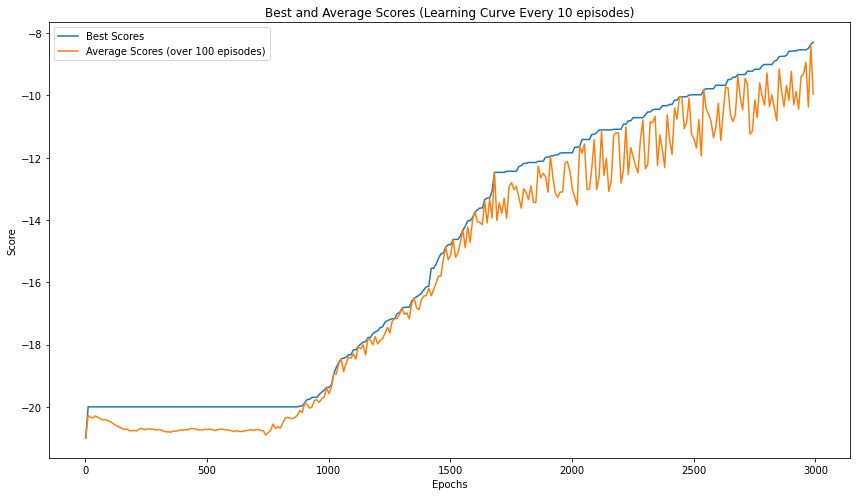

In [106]:
import numpy as np
import matplotlib.pyplot as plt

variables_file = 'session_variables.npz'
if os.path.exists(variables_file):
    session_variables = np.load(variables_file)
    best_rewards_array = session_variables['best_rewards_array']
    avg_scores_array = session_variables['avg_scores_array']

    
n_episodes = len(avg_scores_array)    
x_axis = np.arange(1, n_episodes + 1) 

every_5_episodes = x_axis[::10]
best_rewards_subset = best_rewards_array[::10]
avg_scores_subset = avg_scores_array[::10]

plt.figure(figsize=(12, 7))

plt.plot(every_5_episodes, best_rewards_subset, label='Best Scores ')
plt.plot(every_5_episodes, avg_scores_subset, label='Average Scores (over 100 episodes)')
plt.title('Best and Average Scores (Learning Curve Every 10 episodes)')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
env = gym.make("MountainCar-v0")
DQN_agent = DQNAgent(input_size=[2], n_actions=3, max_mem_size=50000, batch_size=32, network_clone_interval=500,
                      gamma=0.99, epsilon=1.0, lr=0.005, min_epsilon=0.01, epsilon_decay_rate=0.05)

best_score = -np.inf
scores, eps_history, steps_array, best_rewards_array, avg_scores_array = [], [], [], [], []
num_episodes = 500 
n_episodes_to_avg_over = 25

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    episode_reward = 0
    n_steps = 0
    max_position = - 1.2  
    
    while not done:
        action = DQN_agent.choose_action_eps_greedy(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        # Apply reward shaping(improves performance because the env has SPARSE REWARDS)
        if next_state[0] >= 0.5:  
            reward += 10
        
        done = terminated or truncated
  
        episode_reward += reward
        n_steps += 1


        # Update max_position
        if next_state[0] > max_position:
            max_position = next_state[0]
        
        DQN_agent.store_experience(state, action, reward, next_state, terminated, truncated)
        DQN_agent.learn()
        state = next_state
    
    
    scores.append(episode_reward)
    eps_history.append(DQN_agent.epsilon)
    steps_array.append(n_steps)
    
    avg_score = np.mean(scores[-n_episodes_to_avg_over:])
    
    print('episode:', episode, 'score:', episode_reward,
          'average score %.1f' % avg_score, 'best score %.2f' % best_score,
          'epsilon %.2f' % DQN_agent.epsilon, 'steps', n_steps,
          'max position', max_position) 
    
    if n_steps >= 199:
        print("Failed to finish task in epsoide {}".format(episode))
    else:
        print("Success in epsoide {}, used {} iterations!".format(episode, n_steps))
        
    DQN_agent.decrease_epsilon()
    
    
    if avg_score > best_score:
        best_score = avg_score
    
    avg_scores_array.append(avg_score)
    best_rewards_array.append(best_score)
    

GPU is used
episode: 0 score: -200.0 average score -200.0 best score -inf epsilon 1.00 steps 200 max position -0.46018946
Failed to finish task in epsoide 0
episode: 1 score: -200.0 average score -200.0 best score -200.00 epsilon 0.95 steps 200 max position -0.4339511
Failed to finish task in epsoide 1
episode: 2 score: -200.0 average score -200.0 best score -200.00 epsilon 0.90 steps 200 max position -0.43298957
Failed to finish task in epsoide 2
episode: 3 score: -200.0 average score -200.0 best score -200.00 epsilon 0.85 steps 200 max position -0.40179992
Failed to finish task in epsoide 3
episode: 4 score: -200.0 average score -200.0 best score -200.00 epsilon 0.80 steps 200 max position -0.4102104
Failed to finish task in epsoide 4
episode: 5 score: -200.0 average score -200.0 best score -200.00 epsilon 0.75 steps 200 max position -0.39658028
Failed to finish task in epsoide 5
episode: 6 score: -200.0 average score -200.0 best score -200.00 epsilon 0.70 steps 200 max position -0.4

episode: 55 score: -200.0 average score -200.0 best score -200.00 epsilon 0.01 steps 200 max position -0.3297616
Failed to finish task in epsoide 55
episode: 56 score: -200.0 average score -200.0 best score -200.00 epsilon 0.01 steps 200 max position -0.3462441
Failed to finish task in epsoide 56
episode: 57 score: -200.0 average score -200.0 best score -200.00 epsilon 0.01 steps 200 max position -0.4085466
Failed to finish task in epsoide 57
episode: 58 score: -200.0 average score -200.0 best score -200.00 epsilon 0.01 steps 200 max position -0.22138393
Failed to finish task in epsoide 58
episode: 59 score: -200.0 average score -200.0 best score -200.00 epsilon 0.01 steps 200 max position 0.20467766
Failed to finish task in epsoide 59
episode: 60 score: -200.0 average score -200.0 best score -200.00 epsilon 0.01 steps 200 max position -0.25086772
Failed to finish task in epsoide 60
episode: 61 score: -200.0 average score -200.0 best score -200.00 epsilon 0.01 steps 200 max position -0

episode: 110 score: -200.0 average score -200.0 best score -200.00 epsilon 0.01 steps 200 max position -0.27821133
Failed to finish task in epsoide 110
episode: 111 score: -200.0 average score -200.0 best score -200.00 epsilon 0.01 steps 200 max position 0.28704166
Failed to finish task in epsoide 111
episode: 112 score: -200.0 average score -200.0 best score -200.00 epsilon 0.01 steps 200 max position -0.201989
Failed to finish task in epsoide 112
episode: 113 score: -200.0 average score -200.0 best score -200.00 epsilon 0.01 steps 200 max position -0.3542654
Failed to finish task in epsoide 113
episode: 114 score: -200.0 average score -200.0 best score -200.00 epsilon 0.01 steps 200 max position -0.11804548
Failed to finish task in epsoide 114
episode: 115 score: -200.0 average score -200.0 best score -200.00 epsilon 0.01 steps 200 max position -0.39213237
Failed to finish task in epsoide 115
episode: 116 score: -200.0 average score -200.0 best score -200.00 epsilon 0.01 steps 200 ma

episode: 164 score: -178.0 average score -192.9 best score -193.76 epsilon 0.01 steps 188 max position 0.5148766
Success in epsoide 164, used 188 iterations!
episode: 165 score: -200.0 average score -192.9 best score -192.88 epsilon 0.01 steps 200 max position -0.18272437
Failed to finish task in epsoide 165
episode: 166 score: -200.0 average score -192.9 best score -192.88 epsilon 0.01 steps 200 max position -0.205932
Failed to finish task in epsoide 166
episode: 167 score: -200.0 average score -192.9 best score -192.88 epsilon 0.01 steps 200 max position -0.18462837
Failed to finish task in epsoide 167
episode: 168 score: -200.0 average score -192.9 best score -192.88 epsilon 0.01 steps 200 max position -0.05712502
Failed to finish task in epsoide 168
episode: 169 score: -200.0 average score -192.9 best score -192.88 epsilon 0.01 steps 200 max position -0.27865458
Failed to finish task in epsoide 169
episode: 170 score: -200.0 average score -192.9 best score -192.88 epsilon 0.01 step

episode: 218 score: -200.0 average score -183.9 best score -182.44 epsilon 0.01 steps 200 max position -0.2645022
Failed to finish task in epsoide 218
episode: 219 score: -200.0 average score -183.9 best score -182.44 epsilon 0.01 steps 200 max position -0.09372138
Failed to finish task in epsoide 219
episode: 220 score: -200.0 average score -183.9 best score -182.44 epsilon 0.01 steps 200 max position -0.2126202
Failed to finish task in epsoide 220
episode: 221 score: -200.0 average score -185.3 best score -182.44 epsilon 0.01 steps 200 max position 0.112651855
Failed to finish task in epsoide 221
episode: 222 score: -156.0 average score -183.5 best score -182.44 epsilon 0.01 steps 166 max position 0.5371547
Success in epsoide 222, used 166 iterations!
episode: 223 score: -122.0 average score -180.4 best score -182.44 epsilon 0.01 steps 132 max position 0.50004977
Success in epsoide 223, used 132 iterations!
episode: 224 score: -200.0 average score -180.4 best score -180.40 epsilon 0.

episode: 272 score: -200.0 average score -175.4 best score -166.40 epsilon 0.01 steps 200 max position 0.43766898
Failed to finish task in epsoide 272
episode: 273 score: -200.0 average score -176.9 best score -166.40 epsilon 0.01 steps 200 max position 0.26829824
Failed to finish task in epsoide 273
episode: 274 score: -181.0 average score -176.2 best score -166.40 epsilon 0.01 steps 191 max position 0.51952225
Success in epsoide 274, used 191 iterations!
episode: 275 score: -119.0 average score -172.9 best score -166.40 epsilon 0.01 steps 129 max position 0.52456486
Success in epsoide 275, used 129 iterations!
episode: 276 score: -97.0 average score -170.3 best score -166.40 epsilon 0.01 steps 107 max position 0.5165981
Success in epsoide 276, used 107 iterations!
episode: 277 score: -106.0 average score -166.6 best score -166.40 epsilon 0.01 steps 116 max position 0.5113764
Success in epsoide 277, used 116 iterations!
episode: 278 score: -139.0 average score -164.1 best score -166.4

episode: 325 score: -200.0 average score -170.2 best score -151.60 epsilon 0.01 steps 200 max position 0.17929883
Failed to finish task in epsoide 325
episode: 326 score: -130.0 average score -168.6 best score -151.60 epsilon 0.01 steps 140 max position 0.5141595
Success in epsoide 326, used 140 iterations!
episode: 327 score: -200.0 average score -170.0 best score -151.60 epsilon 0.01 steps 200 max position -0.023459062
Failed to finish task in epsoide 327
episode: 328 score: -154.0 average score -169.8 best score -151.60 epsilon 0.01 steps 164 max position 0.5130491
Success in epsoide 328, used 164 iterations!
episode: 329 score: -181.0 average score -169.6 best score -151.60 epsilon 0.01 steps 191 max position 0.51303166
Success in epsoide 329, used 191 iterations!
episode: 330 score: -146.0 average score -168.0 best score -151.60 epsilon 0.01 steps 156 max position 0.5368578
Success in epsoide 330, used 156 iterations!
episode: 331 score: -143.0 average score -169.4 best score -151

episode: 378 score: -142.0 average score -125.7 best score -125.36 epsilon 0.01 steps 152 max position 0.5420727
Success in epsoide 378, used 152 iterations!
episode: 379 score: -110.0 average score -125.6 best score -125.36 epsilon 0.01 steps 120 max position 0.5062753
Success in epsoide 379, used 120 iterations!
episode: 380 score: -78.0 average score -125.3 best score -125.36 epsilon 0.01 steps 88 max position 0.5155605
Success in epsoide 380, used 88 iterations!
episode: 381 score: -139.0 average score -127.3 best score -125.32 epsilon 0.01 steps 149 max position 0.5243882
Success in epsoide 381, used 149 iterations!
episode: 382 score: -143.0 average score -127.6 best score -125.32 epsilon 0.01 steps 153 max position 0.5420727
Success in epsoide 382, used 153 iterations!
episode: 383 score: -171.0 average score -128.2 best score -125.32 epsilon 0.01 steps 181 max position 0.50859976
Success in epsoide 383, used 181 iterations!
episode: 384 score: -141.0 average score -128.5 best s

episode: 430 score: -85.0 average score -127.7 best score -125.32 epsilon 0.01 steps 95 max position 0.5088386
Success in epsoide 430, used 95 iterations!
episode: 431 score: -162.0 average score -127.6 best score -125.32 epsilon 0.01 steps 172 max position 0.5067329
Success in epsoide 431, used 172 iterations!
episode: 432 score: -121.0 average score -127.4 best score -125.32 epsilon 0.01 steps 131 max position 0.523473
Success in epsoide 432, used 131 iterations!
episode: 433 score: -178.0 average score -130.3 best score -125.32 epsilon 0.01 steps 188 max position 0.5434869
Success in epsoide 433, used 188 iterations!
episode: 434 score: -159.0 average score -132.6 best score -125.32 epsilon 0.01 steps 169 max position 0.5033225
Success in epsoide 434, used 169 iterations!
episode: 435 score: -164.0 average score -133.9 best score -125.32 epsilon 0.01 steps 174 max position 0.5168578
Success in epsoide 435, used 174 iterations!
episode: 436 score: -190.0 average score -135.4 best sco

episode: 483 score: -160.0 average score -117.4 best score -113.00 epsilon 0.01 steps 170 max position 0.50610036
Success in epsoide 483, used 170 iterations!
episode: 484 score: -109.0 average score -117.9 best score -113.00 epsilon 0.01 steps 119 max position 0.50163627
Success in epsoide 484, used 119 iterations!
episode: 485 score: -136.0 average score -116.7 best score -113.00 epsilon 0.01 steps 146 max position 0.5232875
Success in epsoide 485, used 146 iterations!
episode: 486 score: -165.0 average score -118.0 best score -113.00 epsilon 0.01 steps 175 max position 0.51852226
Success in epsoide 486, used 175 iterations!
episode: 487 score: -95.0 average score -116.3 best score -113.00 epsilon 0.01 steps 105 max position 0.5076381
Success in epsoide 487, used 105 iterations!
episode: 488 score: -141.0 average score -118.0 best score -113.00 epsilon 0.01 steps 151 max position 0.5055602
Success in epsoide 488, used 151 iterations!
episode: 489 score: -80.0 average score -115.5 bes

### Plot the learning curve for Mountain Car

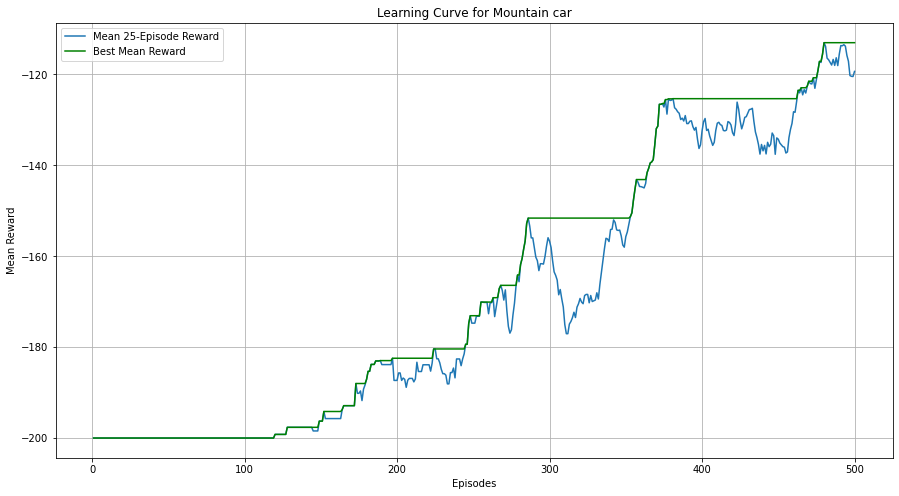

In [52]:
num_episodes = 500
plt.figure(figsize=(15, 8))
plt.plot(np.arange(1, num_episodes + 1), avg_scores_array[:500], label=f"Mean 25-Episode Reward")
plt.plot(np.arange(1, num_episodes + 1), best_rewards_array[:500], 'g', label="Best Mean Reward")
plt.xlabel("Episodes")
plt.ylabel("Mean Reward")
plt.legend()
plt.title("Learning Curve for Mountain car")
plt.grid(True)
plt.show()

###  In the case of MountainCar-v0 environment do plot a graph (one graph) that explains the action choices of the trained agent for various values of position and velocity.

In [36]:
num_positions = 30 
num_velocities = 30 
num_actions = 3  
num_episodes_test = 50
env = gym.make("MountainCar-v0")


action_choices = np.zeros((num_positions, num_velocities, num_actions), dtype=np.int32)

for _ in range(num_episodes_test):  
    state, _ = env.reset()
    done = False

    while not done:
        action = DQN_agent.choose_deterministic_action_greedy(state)  
        next_state, reward, terminated, truncated,  _ = env.step(action)
        
        position = state[0]
        velocity = state[1]
        position_bin = int((position - env.observation_space.low[0]) / (env.observation_space.high[0] - env.observation_space.low[0]) * num_positions)
        velocity_bin = int((velocity - env.observation_space.low[1]) / (env.observation_space.high[1] - env.observation_space.low[1]) * num_velocities)
        action_choices[position_bin][velocity_bin][action] += 1
        
        done = terminated or truncated
        state = next_state

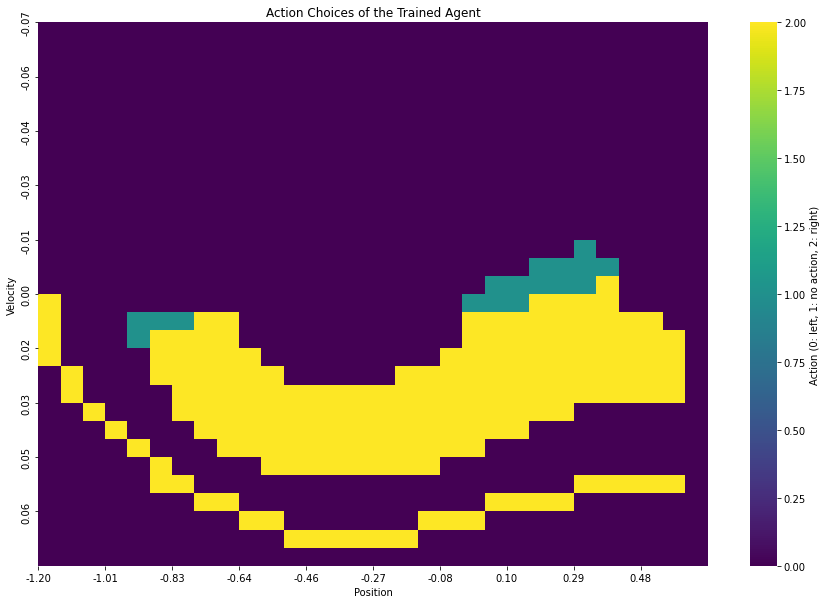

In [35]:
plt.figure(figsize=(15, 10))

position_values = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num_positions)
velocity_values = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num_velocities)

heatmap = sns.heatmap(action_choices.argmax(axis=2).T, cmap="viridis", cbar_kws={'label': "Action (0: left, 1: no action, 2: right)"})
heatmap.set_xticks(np.arange(0, num_positions, num_positions // 10))
heatmap.set_xticklabels(['%.2f' % val for val in position_values[::num_positions // 10]])
heatmap.set_yticks(np.arange(0, num_velocities, num_velocities // 10))
heatmap.set_yticklabels(['%.2f' % val for val in velocity_values[::num_velocities // 10]])

plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Action Choices of the Trained Agent')

plt.show()

## ANSWER 1(b): Action choices of the trained agent
###  The lower half of the plot(velocity is positive i.e Moving towards the right): Most of it is yellow => MOVE RIGHT
    - Most of the time when the car is moving right with some velocity, the agent chooses to move right and increase the velocity in order to reach the flag
    - However, sometimes it may choose to move left if it does not have enought velocity because  moving left will help gain momentum and subsequently reach the top 
    - Around -0.83(on top of left), it may even choose not to do anything because it is on top of left and even without any force, it may still be able to reach the right side top 
    
### The upper half of the plot(velocity is negative i.e Moving towards the left): Most of it is violet => MOVE LEFT
    - Most of the time when the car is moving left with some velocity, the agent chooses to continue to move left as it will help gain momentum
    - If it chooses to move right then it is opposing the current movement and hence will take more time to reach, so the traind agent chooses to move left
    - Around 0 to 0.3(on top of right), it may even choose not to do anything because it is on top of right and even without any force, it will still roll downhill and reach the left top and then gain momentum.
    


### Q 1 (c) The DQN implementation in the above question involves choosing suitable values for a number of hyper-parameters. Choose one hyper-parameter of your choice and run at least three other settings of this hyper-parameter, in addition to the one used in sub-question 1, and plot all four learning curves on the same graph.

In [37]:
def train_agent(epsilon_decay_rate):
    env = gym.make("MountainCar-v0")
    
    # Initialize your DQN agent with the chosen hyperparameters
    DQN_agent = DQNAgent(input_size=[2], n_actions=3, max_mem_size=50000, batch_size=32, network_clone_interval=500,
                          gamma=0.99, epsilon=1.0, lr=0.005, min_epsilon=0.01, epsilon_decay_rate=epsilon_decay_rate)

    scores, eps_history, steps_array, avg_scores_array = [], [], [], []
    num_episodes = 500 

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        n_steps = 0

        while not done:
            action = DQN_agent.choose_action_eps_greedy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Apply reward shaping
            if next_state[0] >= 0.5:  
                reward += 10

            done = terminated or truncated

            episode_reward += reward
            n_steps += 1

            DQN_agent.store_experience(state, action, reward, next_state, terminated, truncated)
            DQN_agent.learn()
            state = next_state


        scores.append(episode_reward)
        eps_history.append(DQN_agent.epsilon)
        steps_array.append(n_steps)

        avg_score = np.mean(scores[-100:])
        DQN_agent.decrease_epsilon()
        avg_scores_array.append(avg_score)
    

    return avg_scores_array, eps_history, steps_array

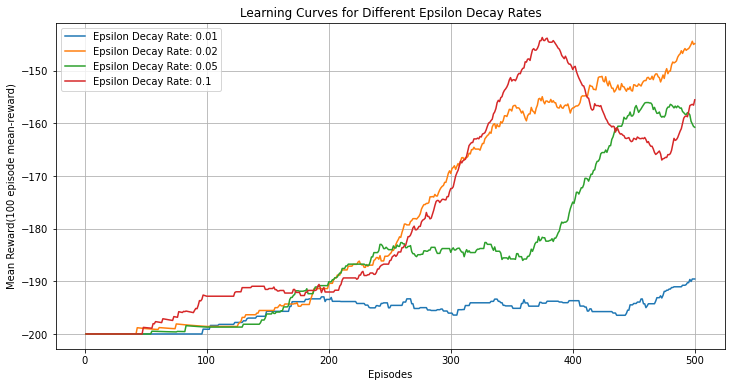

In [38]:
epsilon_decay_rates = [0.01, 0.02, 0.05, 0.1] 
learning_curves = []

for epsilon_decay_rate in epsilon_decay_rates:
    scores, eps_history, steps_array = train_agent(epsilon_decay_rate)
    learning_curves.append(scores)

    
plt.figure(figsize=(12, 6))
for i, epsilon_decay_rate in enumerate(epsilon_decay_rates):
    plt.plot(np.arange(1, len(learning_curves[i]) + 1), learning_curves[i], label=f"Epsilon Decay Rate: {epsilon_decay_rate}")

plt.xlabel("Episodes")
plt.ylabel("Mean Reward(100 episode mean-reward)")
plt.legend()
plt.title("Learning Curves for Different Epsilon Decay Rates")
plt.grid(True)
plt.show()

## ANSWER 2 (c) : Effect of Epsilon Decay Rate 

#### On Learning Speed 
    - A higher epsilon decay rate(here, 0.1) leads to a more rapid decrease in exploration (i.e., higher exploitation), causing the agent to focus on exploiting known actions earlier in training.
    - In contrast, a slower epsilon decay rate (e.g., 0.01) retains exploration for a longer duration, leading to a slower transition to exploitation. The agent continues to explore more, which may slow down the learning rate but provide a more stable learning. 

#### On stability 
    - Though a higher epsilon decay rate may seem to increase the learing speed,it may not be stable because it may not have    explored enough
    - Lower decay rates, like 0.01, provide more stability by preserving exploration for an extended period. 
      While the stability is desirable, it comes at the cost of slower learning.
 
 
- A moderate decay rate however(here 0.02 or 0.05) can get the best of the 2 extreme worlds. 
- This balanced approach leads to more consistent learning, efficient convergence, and improved overall performance.


# PART 2: Policy Gradient

In [ ]:
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gymnasium as gym
import copy

In [2]:
env = gym.make("CartPole-v1")
print("CARTPOLE-V1")
print("State Space:", env.observation_space)
print("Action Space:", env.action_space)
print("\n")

total_reward = 0
num_episodes = 5 

for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    n_steps = 0
    
    while not done:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        n_steps += 1
        done = terminated or truncated
        
    total_reward += episode_reward
    print(f"Done={done}, Last state shape={np.array(next_state).shape}, Last step Reward={reward}")
    print(f"Episode {episode + 1}: Total Reward = {episode_reward}: Total steps = {n_steps}\n")

# Calculate the average reward
average_reward = total_reward / num_episodes
print("Average Reward:", average_reward)

CARTPOLE-V0
State Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action Space: Discrete(2)


Done=True, Last state shape=(4,), Last step Reward=1.0
Episode 1: Total Reward = 23.0: Total steps = 23

Done=True, Last state shape=(4,), Last step Reward=1.0
Episode 2: Total Reward = 20.0: Total steps = 20

Done=True, Last state shape=(4,), Last step Reward=1.0
Episode 3: Total Reward = 31.0: Total steps = 31

Done=True, Last state shape=(4,), Last step Reward=1.0
Episode 4: Total Reward = 28.0: Total steps = 28

Done=True, Last state shape=(4,), Last step Reward=1.0
Episode 5: Total Reward = 88.0: Total steps = 88

Average Reward: 38.0


### Observations(Cartpole)
- The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.
    - 0 = Push cart to left, 1 = Push cart to Right
    
    
- The observation is a ndarray with shape (4,) with the values corresponding to the following positions and velocities:

|Num | Observation |  Min   |  Max |
|:--------:|:--------:|:--------:|:--------:|
|0 |  Cart Position  |-4.8 | 4.8 |
|1 |Cart Velocity | -$\inf$ | $\inf$ |
|2 | Pole Angle | ~ -0.418 rad (-24°) |~ 0.418 rad (24°) |
|3 | Pole Angular Velocity | -$\inf$ | $\inf$ |

In [16]:
# !pip install gymnasium[box2d]

In [3]:
env = gym.make("LunarLander-v2")
print("Lunar Lander")
print("State Space:", env.observation_space)
print("Action Space:", env.action_space)
print("\n")

total_reward = 0
num_episodes = 5 

for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    n_steps = 0
    
    while not done:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        n_steps += 1
        done = terminated or truncated
        
    total_reward += episode_reward
    print(f"Done={done}, Last state shape={np.array(next_state).shape}, Last step Reward={reward}")
    print(f"Episode {episode + 1}: Total Reward = {episode_reward}: Total steps = {n_steps}\n")

# Calculate the average reward
average_reward = total_reward / num_episodes
print("Average Reward:", average_reward)

Lunar Lander
State Space: Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)
Action Space: Discrete(4)


Done=True, Last state shape=(8,), Last step Reward=-100
Episode 1: Total Reward = -289.5968529040806: Total steps = 99

Done=True, Last state shape=(8,), Last step Reward=-100
Episode 2: Total Reward = -371.5650491395209: Total steps = 86

Done=True, Last state shape=(8,), Last step Reward=-100
Episode 3: Total Reward = -234.922531482941: Total steps = 122

Done=True, Last state shape=(8,), Last step Reward=-100
Episode 4: Total Reward = -217.09069005122723: Total steps = 76

Done=True, Last state shape=(8,), Last step Reward=-100
Episode 5: Total Reward = -87.13683671723359: Total steps = 140

Average Reward: -240.06239205900064


### Observations(Lunar lander-v2)
- Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points.
- If the lander crashes, it receives an additional -100 points. 
- If it comes to rest, it receives an additional +100 points. 
- Random agent yields negative rewards less than -100 points mostly as it is likely to crash/ excessive fuel usage.

## 2 b) Implement the policy gradient algorithm with and without the reward to go and advantage normalization functionality

## Vanilla Policy Gradient Algorithm
- Initialize policy network π with parameters $\theta_1$ learning rate $α$ and baseline b
- for n = 1 to N do
    - Sample K trajectories by executing the policy $\pi_{\theta n}$
    - At each time step of each trajectory compute $G_t = \sum_{t'=t}^{\inf}\gamma^{t'-t}r_{t+1}$ and advantage estimate
$A_t = G_t - b(s_t)$
    - Calculate gradient estimate
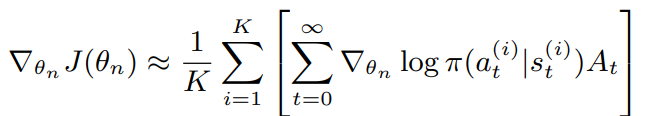

    - Perform gradient update
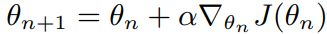




In [40]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(PolicyNetwork , self).__init__()
        self.fc1 = nn.Linear(state_size, 32)           # hidden size 1
        self.fc2 = nn.Linear(32, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.softmax(self.fc2(x) , dim = -1)
        
        return x
    
class VanillaPolicyGradient():
    def __init__(self, env_name, n_train_iterations, batch_size, gamma=0.99, lr=0.003):
        env = gym.make(env_name)
        state_size =  env.observation_space.shape[0]
        action_size = env.action_space.n
        self.state_size = state_size
        self.action_size = action_size
        self.n_train_iterations = n_train_iterations
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.eval_ctr = 1
        self.policy = PolicyNetwork(state_size, action_size)
        self.optimiser = T.optim.Adam(self.policy.parameters(), lr=lr)
        
    
    def train(self, env_name, evaluation_freq=5, reward_to_go=True, advantage_normalisation=True):
        env = gym.make(env_name)
        avg_return_plot, eval_avg_return_plot = [], []
        
        for epoch in range(self.n_train_iterations):
            
            # Sample K trajectories {s1, a1, r1, s2, a2, r2, ......... sk, ak, rk} using current policy
            trajectories_actions, trajectories_states, trajectories_rewards, log_prob_actions = [] , [], [], []
            avg_re = 0
            
            for episode in range(self.batch_size):
                state, _ = env.reset()
                done = False
                episode_action_sequence, episode_state_sequence, episode_reward_sequence =  [], [], []
                
                while not done:
                    action_prob = self.policy(T.tensor(state)).detach().numpy()
                    a = np.random.choice(self.action_size, 1, p=action_prob)
                    action = a[0]    
                    next_state, reward, terminated, truncated, _ = env.step(action)

                    avg_re += reward
                    done = terminated or truncated
                    episode_state_sequence.append(state)
                    state = next_state
                    episode_action_sequence.append(action)
                    episode_reward_sequence.append(reward)                           
            
                trajectories_actions.append(episode_action_sequence)
                trajectories_rewards.append(episode_reward_sequence)
                trajectories_states.append(episode_state_sequence)               
            
#             print(f"Epoch:{epoch} AVERAGE RETURN  =", avg_re/self.batch_size)
            
            avg_return_plot.append(avg_re/self.batch_size)
            
            # Depending on reward to go is set to True or False, calculate Gts    
            G = self.calculate_Gts(trajectories_rewards, reward_to_go)
            
            b = self.calculate_mean_baseline(trajectories_rewards)
            advantage_estimates = [[G[i][j] - b for j in range(len(G[i]))] for i in range(len(G))]
            
            # Depending on advantage normalisation is set to True or False
            if advantage_normalisation:
                A = self.normalize_advantages(advantage_estimates)
            else:
                A = advantage_estimates
                
            self.optimiser.zero_grad()
            loss = T.tensor(0.0)  # Initialize loss as a tensor

            for i in range(len(trajectories_states)):
                for j in range(len(trajectories_states[i])):
                    # Make sure state tensor has requires_grad=True
                    state_tensor = T.tensor(trajectories_states[i][j], requires_grad=True)

                    # Ensure that action_probs is created without detaching or detaching operations
                    action_probs = self.policy(state_tensor)

                    log_prob = T.log(action_probs[trajectories_actions[i][j]]) 

                    loss += -log_prob * A[i][j]  # Use A[i][j] with requires_grad=True to get the advantage for this specific action

            # Calculate the mean of the loss
            loss = loss/self.batch_size

            loss.backward()
            self.optimiser.step()
            
            if epoch % evaluation_freq == 0:      
                avg_return = self.calculate_average_return(env, num_eval_episodes=10)
                eval_avg_return_plot.append(avg_return)
                if epoch % 10 == 0:
                    print(f"Epoch {epoch} - Average Return of 10 evaluation episodes: {avg_return}")

                           
        return avg_return_plot, eval_avg_return_plot    
     
    
    def calculate_Gts(self, trajectories_rewards, reward_to_go):
        G = []
        for episode_rewards in trajectories_rewards:
            episode_length = len(episode_rewards)
            discounts = np.array([self.gamma ** i for i in range(episode_length)])
            if reward_to_go:
                G_episode = [np.sum(np.array(episode_rewards[i:]) * discounts[:episode_length - i]) for i in range(episode_length)]
            else:
                total_return = np.sum(episode_rewards)
                G_episode = [total_return * discounts[0]] * episode_length

            G.append(G_episode)

        return G

    
    def calculate_mean_baseline(self, trajectories_rewards):
        episode_sums = [np.sum(episode) for episode in trajectories_rewards]
        mean_baseline = np.mean(episode_sums)
        
        return mean_baseline
    
    
    def normalize_advantages(self, advantages):
        normalized_advantages = []

        for episode_advantages in advantages:
            mean_advantage = np.mean(episode_advantages)
            std_advantage = np.std(episode_advantages)

            if std_advantage == 0:
                std_advantage = 1e-4

            normalized_episode = [(adv - mean_advantage) / std_advantage for adv in episode_advantages]
            normalized_advantages.append(normalized_episode)

        return normalized_advantages
       
                                       
    def calculate_average_return(self, env, num_eval_episodes=5):
        tot_rewards = 0
        
        for _ in range(num_eval_episodes):
            curr_state = env.reset()[0]
            done = False
            while not done:
                action_prob = self.policy(T.tensor(curr_state)).detach().numpy()
                a = np.random.choice(self.action_size, 1, p=action_prob)
                action = a[0]    
                next_state, reward, terminated, truncated, _ = env.step(action)

                done = terminated or truncated
                tot_rewards += reward
                
                curr_state = next_state
            

        avg_return = tot_rewards/num_eval_episodes
        return avg_return
    
   

## Lunar Lander

..........STARTING TRAINING FOR CASE-1 : With Advantage Norm & Reward-to-Go ............
Epoch 0 - Average Return of 10 evaluation episodes: -154.78311728484613
Epoch 10 - Average Return of 10 evaluation episodes: -143.6814642645615
Epoch 20 - Average Return of 10 evaluation episodes: -95.41387242567795
Epoch 30 - Average Return of 10 evaluation episodes: -23.455528916176615
Epoch 40 - Average Return of 10 evaluation episodes: -86.69948095657891
Epoch 50 - Average Return of 10 evaluation episodes: 11.149097149241294
Epoch 60 - Average Return of 10 evaluation episodes: 4.927105473288992
Epoch 70 - Average Return of 10 evaluation episodes: 39.43575557874129
Epoch 80 - Average Return of 10 evaluation episodes: 88.5899361523474
Epoch 90 - Average Return of 10 evaluation episodes: 61.692469699221796
Epoch 100 - Average Return of 10 evaluation episodes: 98.74808530388677
Epoch 110 - Average Return of 10 evaluation episodes: 100.4089671111982
Epoch 120 - Average Return of 10 evaluation episod

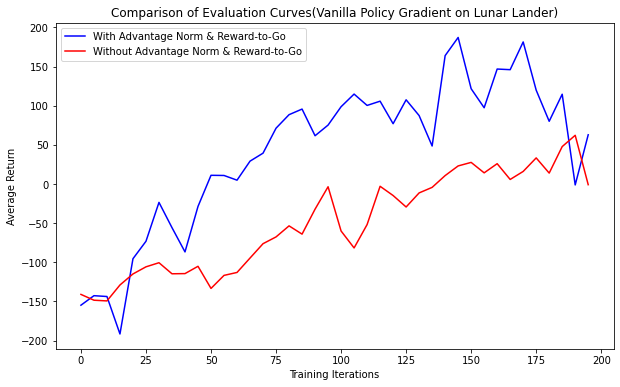

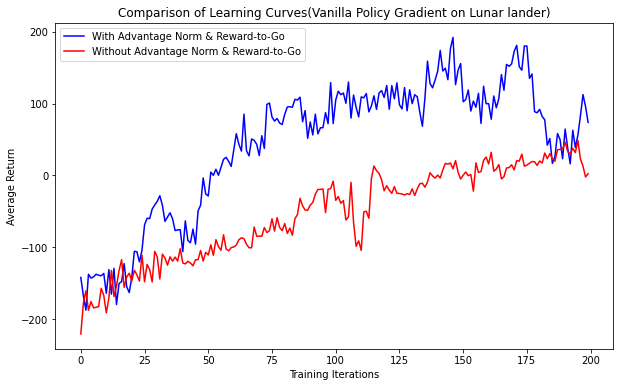

In [42]:
env_name = "LunarLander-v2"
n_train_iterations = 200
n_trajectories_per_iter = 20
evaluation_freq = 5
lr = 0.01

vpg = VanillaPolicyGradient(env_name, n_train_iterations, n_trajectories_per_iter, gamma=0.99, lr=lr)

print("..........STARTING TRAINING FOR CASE-1 : With Advantage Norm & Reward-to-Go ............")

# With advantage normalization and reward-to-go
learning_curve_with_adv_norm, eval_curve_with_adv_norm = vpg.train(env_name, evaluation_freq, reward_to_go=True, advantage_normalisation=True)

print("..........STARTING TRAINING FOR CASE-2 : Without Advantage Norm & Reward-to-Go ............")

# Without advantage normalization and reward-to-go
vpg = VanillaPolicyGradient(env_name, state_size, action_size, n_train_iterations, n_trajectories_per_iter, gamma=0.99, lr=lr)  # Reinitialize
learning_curve_without_adv_norm, eval_curve_without_adv_norm = vpg.train(env_name, evaluation_freq, reward_to_go=False, advantage_normalisation=False)


x = np.arange(0, n_train_iterations, evaluation_freq)
plt.figure(figsize=(10, 6))
plt.plot(x, eval_curve_with_adv_norm, 'b-', label="With Advantage Norm & Reward-to-Go")
plt.plot(x, eval_curve_without_adv_norm, 'r-', label="Without Advantage Norm & Reward-to-Go")
plt.xlabel("Training Iterations")
plt.ylabel("Average Return")
plt.legend()
plt.title("Comparison of Evaluation Curves(Vanilla Policy Gradient on Lunar Lander)")
plt.show()


x = np.arange(0, n_train_iterations)
plt.figure(figsize=(10, 6))
plt.plot(x, learning_curve_with_adv_norm, 'b-', label="With Advantage Norm & Reward-to-Go")
plt.plot(x, learning_curve_without_adv_norm, 'r-', label="Without Advantage Norm & Reward-to-Go")
plt.xlabel("Training Iterations")
plt.ylabel("Average Return")
plt.legend()
plt.title("Comparison of Learning Curves(Vanilla Policy Gradient on Lunar lander)")
plt.show()


### Note: Cartpole-v1 is used because Cartpole-v1 is newer

..........STARTING TRAINING FOR CASE-1 : With Advantage Norm & Reward-to-Go ............
Epoch 0 - Average Return of 10 evaluation episodes: 23.6
Epoch 10 - Average Return of 10 evaluation episodes: 31.1
Epoch 20 - Average Return of 10 evaluation episodes: 26.7
Epoch 30 - Average Return of 10 evaluation episodes: 34.6
Epoch 40 - Average Return of 10 evaluation episodes: 56.8
Epoch 50 - Average Return of 10 evaluation episodes: 51.6
Epoch 60 - Average Return of 10 evaluation episodes: 54.6
Epoch 70 - Average Return of 10 evaluation episodes: 94.5
Epoch 80 - Average Return of 10 evaluation episodes: 129.2
Epoch 90 - Average Return of 10 evaluation episodes: 268.0
Epoch 100 - Average Return of 10 evaluation episodes: 356.9
Epoch 110 - Average Return of 10 evaluation episodes: 337.4
Epoch 120 - Average Return of 10 evaluation episodes: 477.5
Epoch 130 - Average Return of 10 evaluation episodes: 468.0
Epoch 140 - Average Return of 10 evaluation episodes: 484.0
..........STARTING TRAINING FO

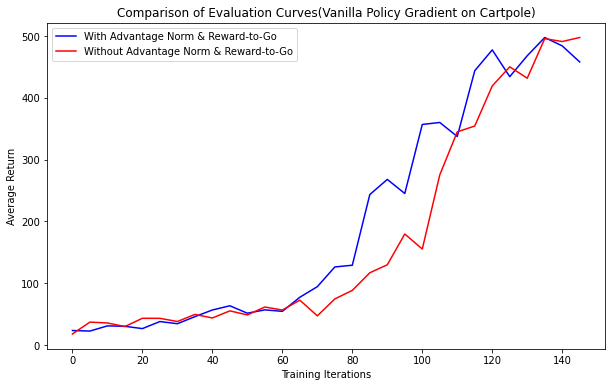

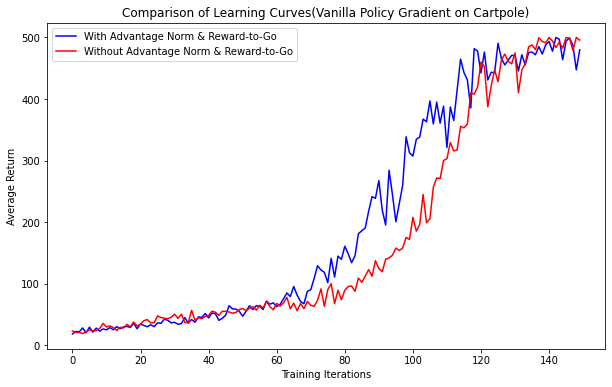

In [41]:
env_name = "CartPole-v1"
n_train_iterations = 150
n_trajectories_per_iter = 20
evaluation_freq = 5

vpg = VanillaPolicyGradient(env_name, n_train_iterations, n_trajectories_per_iter, gamma=0.99)

print("..........STARTING TRAINING FOR CASE-1 : With Advantage Norm & Reward-to-Go ............")

# With advantage normalization and reward-to-go
learning_curve_with_adv_norm, eval_curve_with_adv_norm = vpg.train(env_name, evaluation_freq, reward_to_go=True, advantage_normalisation=True)

print("..........STARTING TRAINING FOR CASE-2 : Without Advantage Norm & Reward-to-Go ............")

# Without advantage normalization and reward-to-go
vpg = VanillaPolicyGradient(env_name, state_size, action_size, n_train_iterations, n_trajectories_per_iter, gamma=0.99)  # Reinitialize
learning_curve_without_adv_norm, eval_curve_without_adv_norm = vpg.train(env_name, evaluation_freq, reward_to_go=False, advantage_normalisation=False)


x = np.arange(0, n_train_iterations, evaluation_freq)
plt.figure(figsize=(10, 6))
plt.plot(x, eval_curve_with_adv_norm, 'b-', label="With Advantage Norm & Reward-to-Go")
plt.plot(x, eval_curve_without_adv_norm, 'r-', label="Without Advantage Norm & Reward-to-Go")
plt.xlabel("Training Iterations")
plt.ylabel("Average Return")
plt.legend()
plt.title("Comparison of Evaluation Curves(Vanilla Policy Gradient on Cartpole)")
plt.show()


x = np.arange(0, n_train_iterations)
plt.figure(figsize=(10, 6))
plt.plot(x, learning_curve_with_adv_norm, 'b-', label="With Advantage Norm & Reward-to-Go")
plt.plot(x, learning_curve_without_adv_norm, 'r-', label="Without Advantage Norm & Reward-to-Go")
plt.xlabel("Training Iterations")
plt.ylabel("Average Return")
plt.legend()
plt.title("Comparison of Learning Curves(Vanilla Policy Gradient on Cartpole)")
plt.show()

###  Evaluation Curve
- The evaluation curve is assessed during training, typically at intervals of every 5 episodes, 
- It involves running the agent on a separate environment for 10 episodes (without updating the policy.)
-  It provides insights into how well the policy generalizes to unseen environments or scenarios.

### Learning Curve 
- The training curve represents the mean reward of the k trajectories sampled every epoch 
- It is calculated at the end of each epoch. 
- It reflects the performance of the agent's policy on the training environment

## Q 2(b)  Attach in your reports, a comparison of learning curve graphs (average return at each iteration) with and without advantage normalization and reward-to-go functionality.

## ANSWER : Comparison of Learing Curves (Both Cases) 

#### With Advantage Normalization and Reward-to-Go:
    - Advantage Normalization and Reward-to-Go work together to give a more reliable and faster training
    - The policy gradient algorithm reaches higher average returns over training iterations.
    -  Learning curves looks more smooth, with less variance in the average return at each iteration.
    
#### Without Advantage Normalisation and Reward-to-Go:
    - Learning curves tend to exhibit more fluctuations/variance in the average return at each iteration.
    - The absence of both the factors lead to slower training and may require more iterations to reach similar average rewards to when advantage normalization and reward-to-go are applied.

## Q2 c) Study and report the impact of batch size on the policy gradient estimates on these environments.

### 1. CARTPOLE

Epoch 0 - Average Return of 10 evaluation episodes: 26.0
Epoch 10 - Average Return of 10 evaluation episodes: 27.8
Epoch 20 - Average Return of 10 evaluation episodes: 31.8
Epoch 30 - Average Return of 10 evaluation episodes: 28.1
Epoch 40 - Average Return of 10 evaluation episodes: 43.0
Epoch 50 - Average Return of 10 evaluation episodes: 42.4
Epoch 60 - Average Return of 10 evaluation episodes: 71.8
Epoch 70 - Average Return of 10 evaluation episodes: 46.9
Epoch 80 - Average Return of 10 evaluation episodes: 70.2
Epoch 90 - Average Return of 10 evaluation episodes: 79.0
Epoch 100 - Average Return of 10 evaluation episodes: 55.5
Epoch 110 - Average Return of 10 evaluation episodes: 134.9
Epoch 120 - Average Return of 10 evaluation episodes: 136.2
Epoch 130 - Average Return of 10 evaluation episodes: 209.9
Epoch 140 - Average Return of 10 evaluation episodes: 271.4
Epoch 0 - Average Return of 10 evaluation episodes: 15.7
Epoch 10 - Average Return of 10 evaluation episodes: 20.5
Epoch 2

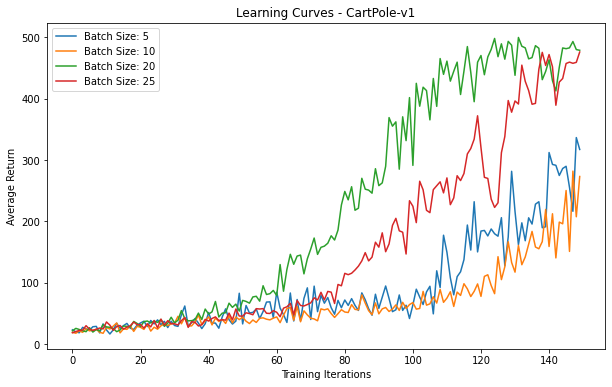

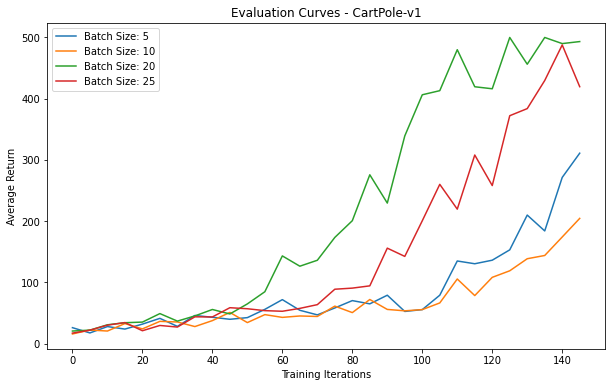

In [43]:
batch_sizes = [5, 10, 20, 25]  

env_name = "CartPole-v1"
env = gym.make(env_name)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
n_train_iterations = 150
evaluation_freq = 5

learning_curves = []
eval_curves = []

for batch_size in batch_sizes:
    vpg = VanillaPolicyGradient(env, state_size, action_size, n_train_iterations, batch_size, gamma=0.99)

    learning_curve, eval_curve = vpg.train(env, evaluation_freq)

    learning_curves.append(learning_curve)
    eval_curves.append(eval_curve)

    
x = np.arange(0, n_train_iterations)
plt.figure(figsize=(10, 6))
for i, batch_size in enumerate(batch_sizes):
    plt.plot(x, learning_curves[i], label=f"Batch Size: {batch_size}")
plt.xlabel("Training Iterations")
plt.ylabel("Average Return")
plt.legend()
plt.title(f"Learning Curves - {env_name}")
plt.show()

x = np.arange(0, n_train_iterations, evaluation_freq)
plt.figure(figsize=(10, 6))
for i, batch_size in enumerate(batch_sizes):
    plt.plot(x, eval_curves[i], label=f"Batch Size: {batch_size}")
plt.xlabel("Training Iterations")
plt.ylabel("Average Return")
plt.legend()
plt.title(f"Evaluation Curves - {env_name}")
plt.show()

## 2. LUNAR LANDER

Epoch 0 - Average Return of 10 evaluation episodes: -190.99506153637554
Epoch 10 - Average Return of 10 evaluation episodes: -187.09116593825416
Epoch 20 - Average Return of 10 evaluation episodes: -268.5468968682506
Epoch 30 - Average Return of 10 evaluation episodes: -145.08093191106826
Epoch 40 - Average Return of 10 evaluation episodes: -150.2638043015142
Epoch 50 - Average Return of 10 evaluation episodes: -95.34688721388314
Epoch 60 - Average Return of 10 evaluation episodes: -145.02683727158222
Epoch 70 - Average Return of 10 evaluation episodes: -113.76425643346735
Epoch 80 - Average Return of 10 evaluation episodes: -111.65493788488592
Epoch 90 - Average Return of 10 evaluation episodes: -96.94822417626726
Epoch 100 - Average Return of 10 evaluation episodes: -17.02980337526682
Epoch 110 - Average Return of 10 evaluation episodes: -0.46572461864717096
Epoch 120 - Average Return of 10 evaluation episodes: -13.379331858899729
Epoch 130 - Average Return of 10 evaluation episodes:

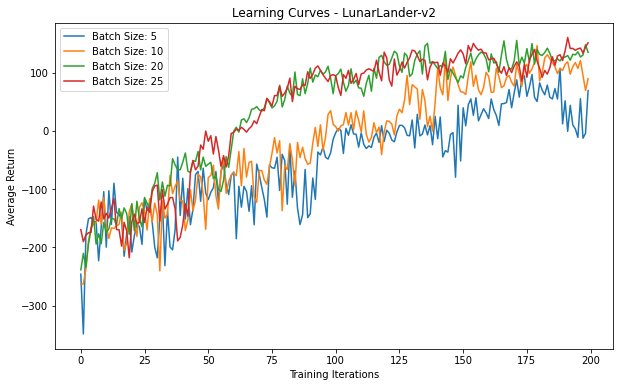

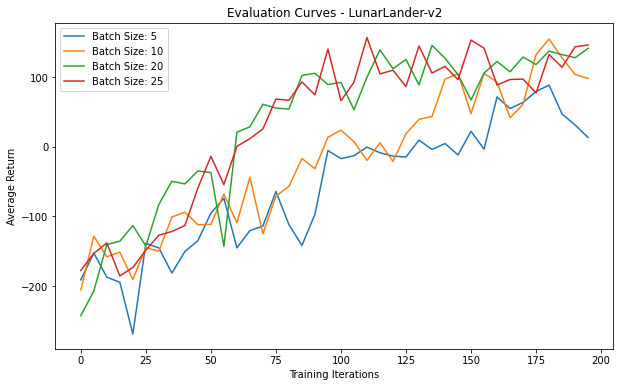

In [44]:
batch_sizes = [5, 10, 20, 25]  

env_name = "LunarLander-v2"
env = gym.make(env_name)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
n_train_iterations = 200
evaluation_freq = 5

learning_curves = []
eval_curves = []

for batch_size in batch_sizes:
    vpg = VanillaPolicyGradient(env, state_size, action_size, n_train_iterations, batch_size, gamma=0.99, lr=0.01)

    learning_curve, eval_curve = vpg.train(env, evaluation_freq)

    learning_curves.append(learning_curve)
    eval_curves.append(eval_curve)

    
x = np.arange(0, n_train_iterations)
plt.figure(figsize=(10, 6))
for i, batch_size in enumerate(batch_sizes):
    plt.plot(x, learning_curves[i], label=f"Batch Size: {batch_size}")
plt.xlabel("Training Iterations")
plt.ylabel("Average Return")
plt.legend()
plt.title(f"Learning Curves - {env_name}")
plt.show()

x = np.arange(0, n_train_iterations, evaluation_freq)
plt.figure(figsize=(10, 6))
for i, batch_size in enumerate(batch_sizes):
    plt.plot(x, eval_curves[i], label=f"Batch Size: {batch_size}")
plt.xlabel("Training Iterations")
plt.ylabel("Average Return")
plt.legend()
plt.title(f"Evaluation Curves - {env_name}")
plt.show()

## ANSWER 2(c) :  Impact of batch size

### On learning speed : 
- If the batch size is too small, it may lead to slower learning as in it takes more epochs to get good rewards, as it provides noisy estimates
- If it is too large, it can slow down training due to increased computation
    
### On Variance & Stability : 
- If it is too small, it may lead to noisier learning curves and less stable training, 
as it results in **more variance in policy gradient estimates**
- Larger batch sizes  offer more stable and less noisy learning curves, however, they may not necessarily scale linearly in terms of performance improvement